In [5]:
import fiftyone as fo
import fiftyone.zoo as foz
import os
import torch
import torch.utils.data
import torchvision
import torchvision.ops 
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from PIL import Image
from torchvision.transforms import functional as func
import cv2
import numpy as np
from detectron2.evaluation.coco_evaluation import instances_to_coco_json
from detectron2.structures import BoxMode
import pickle

Loading config /home/dongheehan/anaconda3/envs/objectdetection/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
Model ready
Found annotations at '/home/dongheehan/fiftyone/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'evaluate-detections-tutorial'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Name:        evaluate-detections-tutorial
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        ['validation']
Sample fields:
    id:                        fiftyone.core.fields.ObjectIdField
    filepath:                  fiftyone.core.fields.StringField
    tags:                      fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                  fiftyone.core.fields.


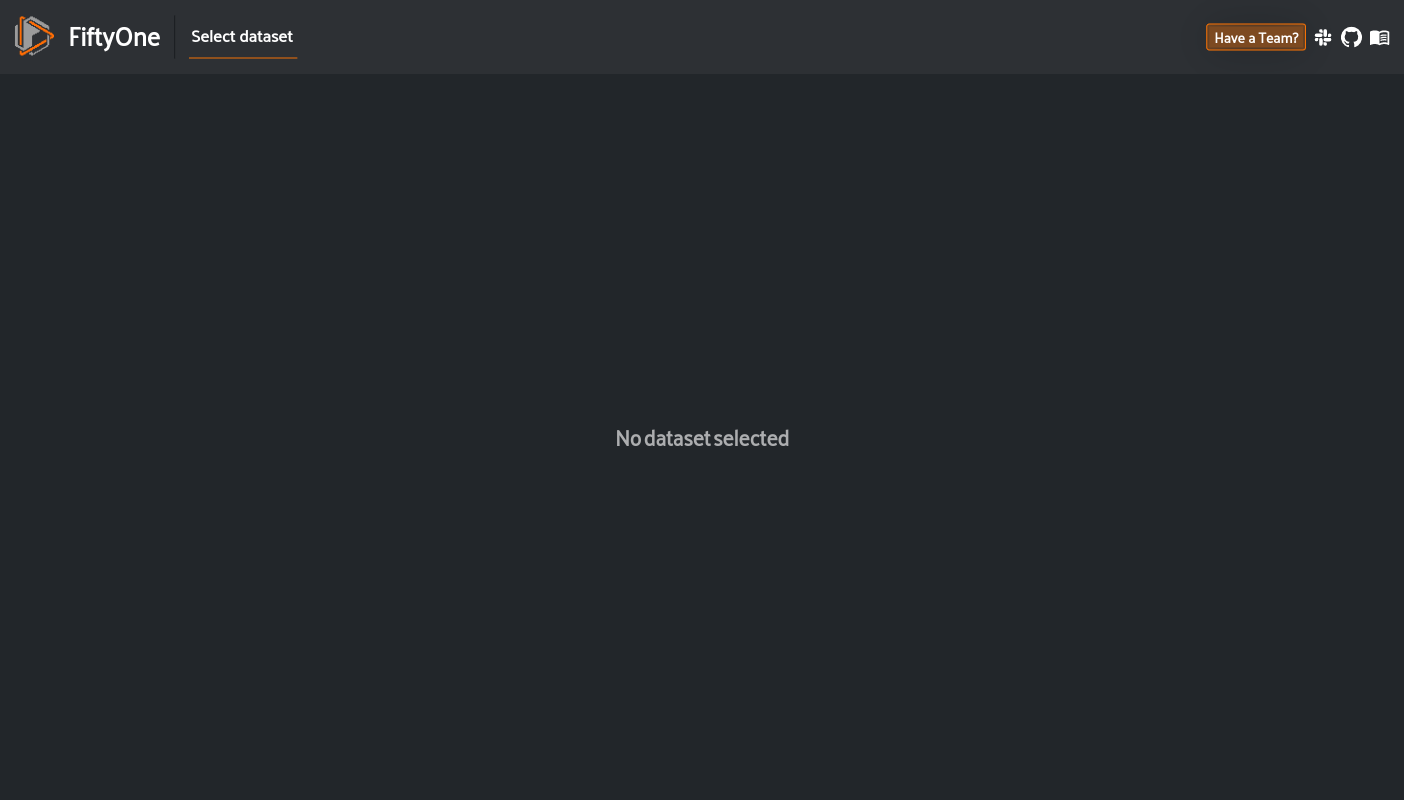

In [6]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

inferencemode = 'COCO-Detection'
expendName = '.yaml'
load_model_name = 'retinanet_R_50_FPN_1x'

# load model
# load model
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file(os.path.join(inferencemode, load_model_name + expendName)))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
#Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(os.path.join(inferencemode, load_model_name + expendName))

PREDICTION_PATH = './predictions'
# load
with open(os.path.join(PREDICTION_PATH, f'{load_model_name}_predictions.pickle'), 'rb') as f:
    model_predictions = pickle.load(f)
    
print("Model ready")

dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    dataset_name="evaluate-detections-tutorial",
)
dataset.persistent = True

# Print some information about the dataset
print(dataset)

# Print a ground truth detection
sample = dataset.first()
print(sample.ground_truth.detections[0])

session = fo.launch_app()

In [7]:
from detectron2.data import MetadataCatalog
# Choose a random subset of 100 samples to add predictions to
predictions_view = dataset.take(5000,seed=51) # limit size

## Get class list
#classes = dataset.default_classes

#Get class list
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
classes = metadata.get("thing_classes", None)

overlabthreshold = 0.15

 100% |███████████████| 5000/5000 [8.0m elapsed, 0s remaining, 11.2 samples/s]      
Finished adding predictions



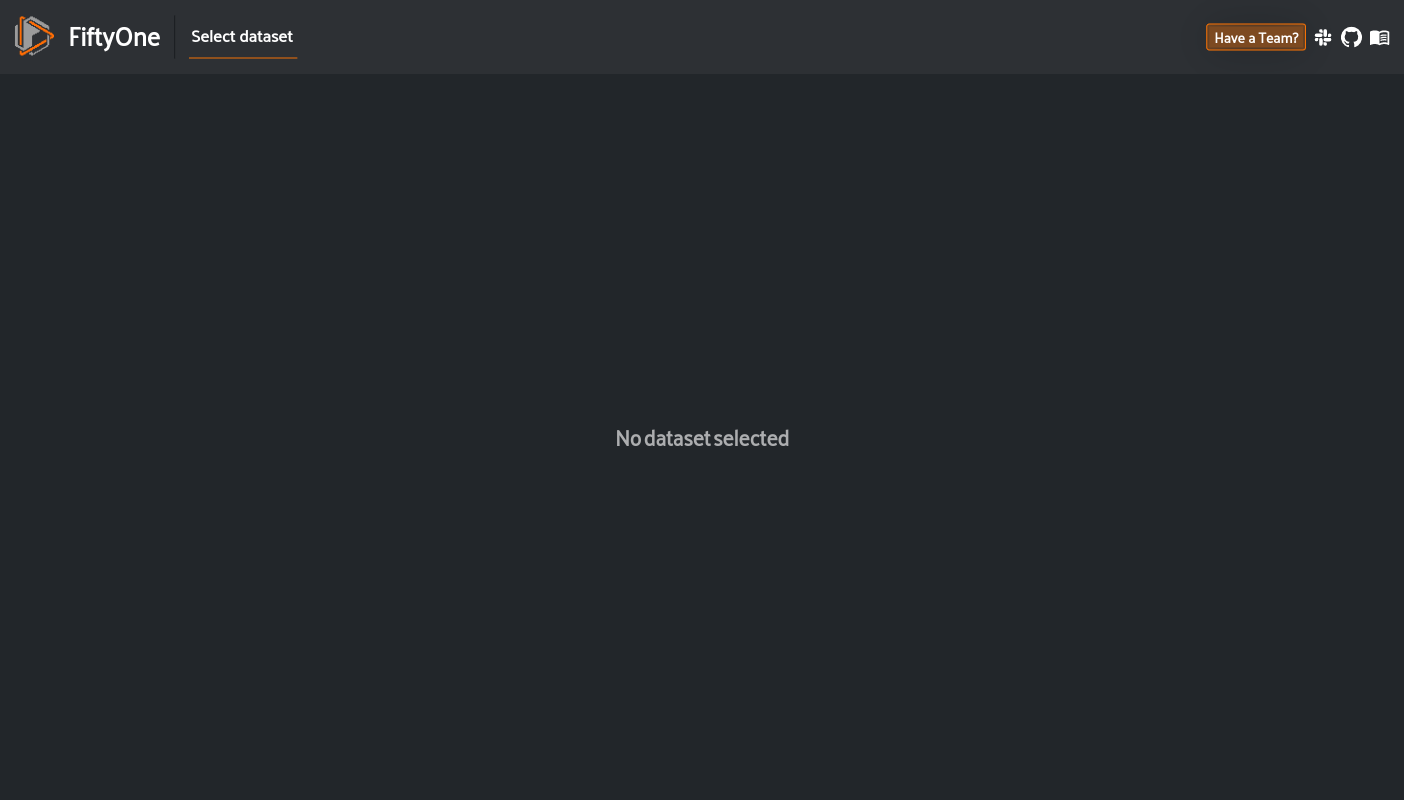


Could not connect session, trying again in 10 seconds




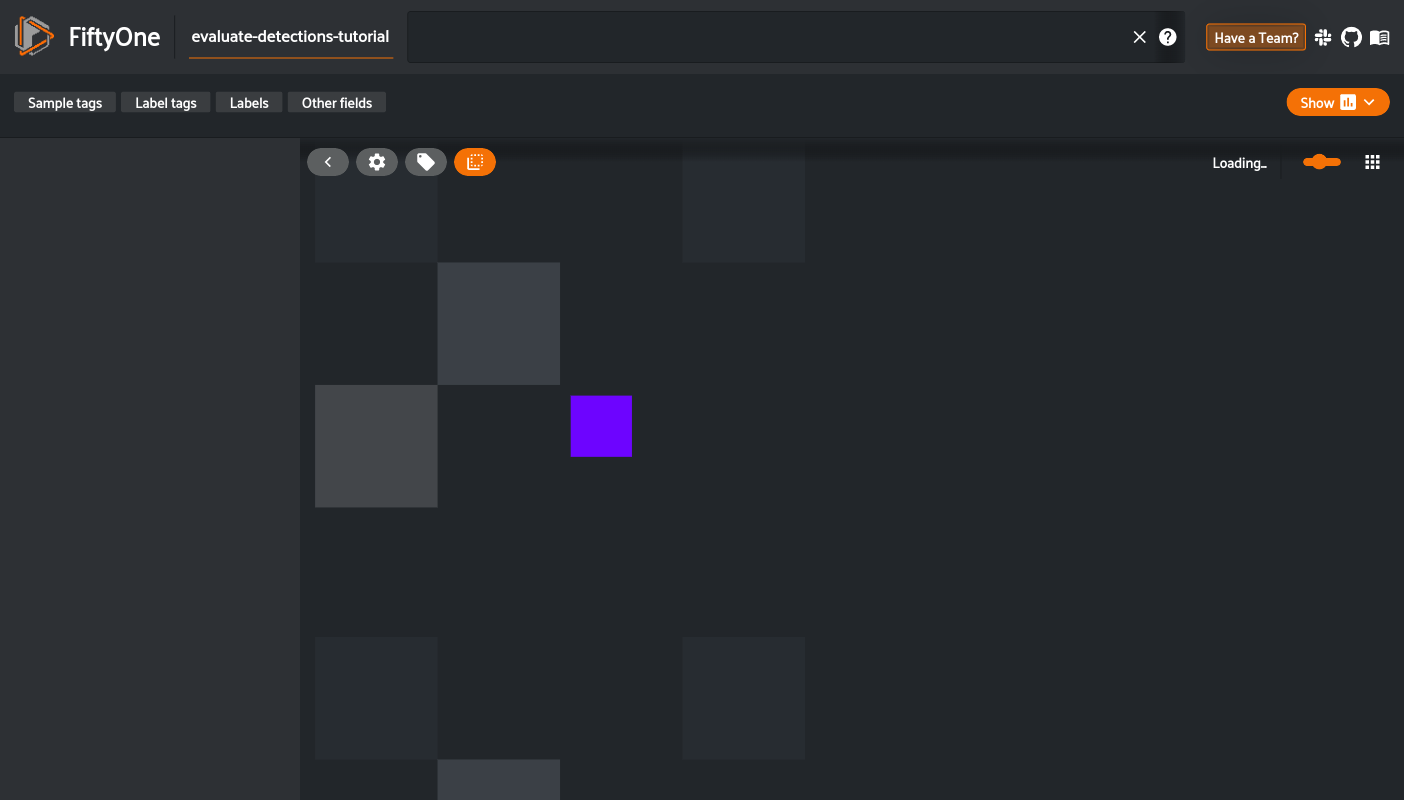


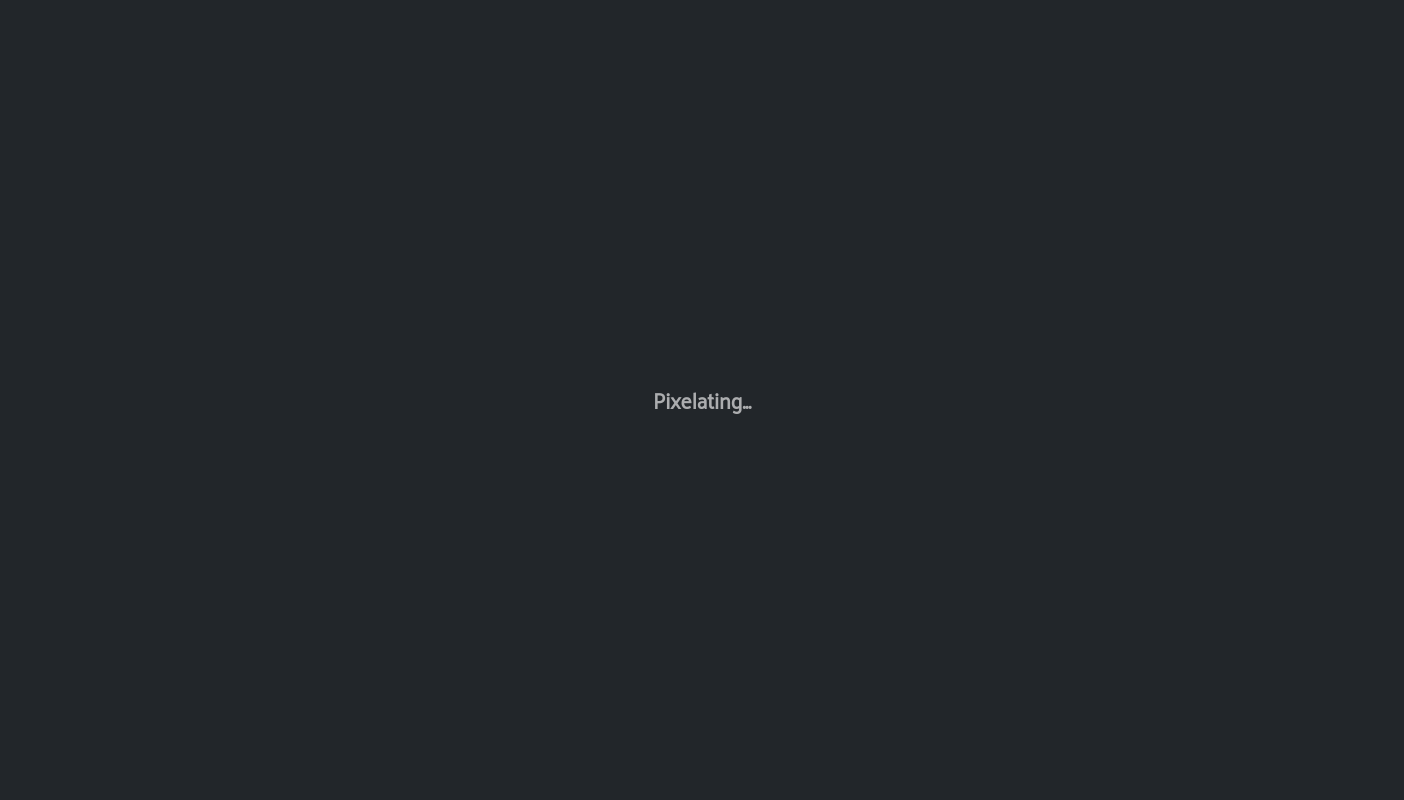

'7ef2a860-9746-4c91-982a-559aa44474b6'

In [8]:

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):

        # Load image
        image = cv2.imread(sample.filepath)
        h, w, c = image.shape

                        # Perform inference
        filename = os.path.basename(sample.filepath)
        prediction = model_predictions[filename]

        boxes =  prediction[0]
        labels = prediction[1]
        scores = prediction[2]
        
        tensor_boxes =  torch.tensor(boxes)
        tensor_scores = torch.tensor(scores)
        results = torchvision.ops.nms(tensor_boxes, tensor_scores, overlabthreshold)

        # Convert detections to FiftyOne format
        detections = []

        for nIndex, (label, score, box) in enumerate(zip(labels, scores, boxes)):

            if (nIndex in results) is False:
                continue

            x, y, width, height = box

            x1 = x
            y1 = y
            x2 = x + width
            y2 = y + height
            
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample[load_model_name] = fo.Detections(detections=detections)
        sample.save()

print("Finished adding predictions")
session.view = None
session.view = predictions_view
session.show()

In [9]:
fiftyone_classes = dataset.default_classes

#Get class list
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
COCO_classes = metadata.get("thing_classes", None)

In [10]:
print(fiftyone_classes)

['0', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', '12', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', '26', 'backpack', 'umbrella', '29', '30', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', '45', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', '66', 'dining table', '68', '69', 'toilet', '71', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', '83', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [11]:
print(COCO_classes)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [22]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = dataset.filter_labels(load_model_name, F("confidence") > 0.15)

In [23]:
print(high_conf_view)

Dataset:     evaluate-detections-tutorial
Media type:  image
Num samples: 4992
Tags:        ['validation']
Sample fields:
    id:                        fiftyone.core.fields.ObjectIdField
    filepath:                  fiftyone.core.fields.StringField
    tags:                      fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth:              fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    retinanet_R_50_FPN_1x:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    retinanet_R_50_FPN_3x:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    retinanet_R_101_FPN_3x:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval2_tp:                  fiftyone.core.fields.IntField
    eval2_fp:                  fiftyone.core.fields

In [24]:
sample = high_conf_view.first()
print(sample.retinanet_R_50_FPN_1x.detections[0])

<Detection: {
    'id': '62a4f433384ad652f650916f',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'chair',
    'bounding_box': BaseList([
        0.4596840858459473,
        0.5151217106922131,
        0.09462947845458984,
        0.23157988355753006,
    ]),
    'mask': None,
    'confidence': 0.8355884552001953,
    'index': None,
    'retinenet_R_50_fpn_1x_iou': 0.8837062172741902,
    'retinenet_R_50_fpn_1x_id': '62a369292fcd7ce179fd131b',
    'retinenet_R_50_fpn_1x': 'tp',
}>


In [ ]:
session.view = high_conf_view

In [26]:
eval_key="retinenet_R_50_fpn_1x"

results = high_conf_view.evaluate_detections(
    load_model_name,
    gt_field="ground_truth",
    eval_key=eval_key,
    compute_mAP=True,
)



Evaluating detections...
 100% |███████████████| 4992/4992 [7.7m elapsed, 0s remaining, 11.9 samples/s]      
Performing IoU sweep...
                                                                                     100% |███████████████| 4992/4992 [3.7m elapsed, 0s remaining, 24.8 samples/s]      


In [27]:
print(dataset.get_evaluation_info(eval_key))

{
    "key": "retinenet_R_50_fpn_1x",
    "version": "0.16.2",
    "timestamp": "2022-06-11T20:10:13.269000",
    "config": {
        "method": "coco",
        "cls": "fiftyone.utils.eval.coco.COCOEvaluationConfig",
        "pred_field": "retinanet_R_50_FPN_1x",
        "gt_field": "ground_truth",
        "iou": 0.5,
        "classwise": true,
        "iscrowd": "iscrowd",
        "use_masks": false,
        "use_boxes": false,
        "tolerance": null,
        "compute_mAP": true,
        "iou_threshs": [
            0.5,
            0.55,
            0.6,
            0.65,
            0.7,
            0.75,
            0.8,
            0.85,
            0.9,
            0.95
        ],
        "max_preds": 100,
        "error_level": 1
    }
}


In [28]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values("ground_truth.detections.label")
classes_top = sorted(counts, key=counts.get, reverse=True)

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top)

                precision    recall  f1-score   support

        person       0.45      0.93      0.61     18041
           car       0.23      0.84      0.36      2408
         chair       0.17      0.74      0.28      2113
          book       0.34      0.86      0.49      2847
        bottle       0.24      0.83      0.38      1389
           cup       0.19      0.79      0.30       948
  dining table       0.11      0.62      0.19       708
 traffic light       0.15      0.70      0.24       658
          bowl       0.17      0.80      0.28       659
       handbag       0.09      0.57      0.15       540
          bird       0.38      0.84      0.52       913
          boat       0.21      0.81      0.33       608
         truck       0.13      0.81      0.23       417
         bench       0.12      0.63      0.20       495
      umbrella       0.25      0.79      0.38       503
           cow       0.37      0.91      0.53       576
        banana       0.31      0.86      0.45  

In [29]:
print(results.mAP())

0.36542831488657923
